
# Set Cover Problem


## Introduction

The set cover problem [[1]](#SetCoverWiki) represents a well-known problem in the fields of combinatorics, computer science, and complexity theory. It is an NP-complete problems.

The problem presents us with a universal set, $\displaystyle U$, and a collection $\displaystyle S$ of subsets of $\displaystyle U$. The goal is to find the smallest possible subfamily, $\displaystyle C \subseteq S$, whose union equals the universal set.

Formally, let's consider a universal set $\displaystyle U = {1, 2, ..., n}$ and a collection $\displaystyle S$ containing $m$ subsets of $\displaystyle U$, $\displaystyle S = {S_1, ..., S_m}$ with $\displaystyle S_i \subseteq U$. The challenge of the set cover problem is to find a subset $\displaystyle C$ of $\displaystyle S$ of minimal size such that $\displaystyle \bigcup_{S_i \in C} S_i = U$.

## Solving with the Classiq platform

We go through the steps of solving the problem with the Classiq platform, using QAOA algorithm [[2](#QAOA)]. The solution is based on defining a pyomo model for the optimization problem we would like to solve.

### Building the Pyomo model from an input

We proceed by defining the pyomo model that will be used on the Classiq platform, using the mathematical formulation defined above:

In [1]:
import itertools
from typing import List

import pyomo.core as pyo


def set_cover(sub_sets: List[List[int]]) -> pyo.ConcreteModel:
    entire_set = set(itertools.chain(*sub_sets))
    n = max(entire_set)
    num_sets = len(sub_sets)
    assert entire_set == set(
        range(1, n + 1)
    ), f"the union of the subsets is {entire_set} not equal to range(1, {n + 1})"

    model = pyo.ConcreteModel()
    model.x = pyo.Var(range(num_sets), domain=pyo.Binary)

    @model.Constraint(entire_set)
    def independent_rule(model, num):
        return sum(model.x[idx] for idx in range(num_sets) if num in sub_sets[idx]) >= 1

    model.cost = pyo.Objective(expr=sum(model.x.values()), sense=pyo.minimize)

    return model

The model contains:

- Binary variable for each subset (model.x) indicating if it is included in the sub-collection.
- Objective rule – the size of the sub-collection.
- Constraint – the sub-collection covers the original set.

In [2]:
sub_sets = sub_sets = [
    [1, 2, 3, 4],
    [2, 3, 4, 5],
    [6, 7],
    [8, 9, 10],
    [1, 6, 8],
    [3, 7, 9],
    [4, 7, 10],
    [2, 5, 8],
]

set_cover_model = set_cover(sub_sets)

In [3]:
set_cover_model.pprint()

2 Set Declarations
    independent_rule_index : Size=1, Index=None, Ordered=False
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   10 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
    x_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    8 : {0, 1, 2, 3, 4, 5, 6, 7}

1 Var Declarations
    x : Size=8, Index=x_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :  None :     1 : False :  True : Binary
          1 :     0 :  None :     1 : False :  True : Binary
          2 :     0 :  None :     1 : False :  True : Binary
          3 :     0 :  None :     1 : False :  True : Binary
          4 :     0 :  None :     1 : False :  True : Binary
          5 :     0 :  None :     1 : False :  True : Binary
          6 :     0 :  None :     1 : False :  True : Binary
          7 :     0 :  None :     1 : False :  True : Binary

1 Objective Declarations
    cost : S

## Setting Up the Classiq Problem Instance

In order to solve the Pyomo model defined above, we use the `CombinatorialProblem` quantum object. Under the hood it tranlastes the Pyomo model to a quantum model of the QAOA algorithm, with a cost function translated from the Pyomo model. We can choose the number of layers for the QAOA ansatz using the argument `num_layers`, and the `penalty_factor`, which will be the coefficient of the constraints term in the cost hamiltonian.

In [4]:
from classiq import *
from classiq.applications.combinatorial_optimization import CombinatorialProblem

combi = CombinatorialProblem(pyo_model=set_cover_model, num_layers=3, penalty_factor=10)

qmod = combi.get_model()

In [5]:
write_qmod(qmod, "set_cover")

## Synthesizing the QAOA Circuit and Solving the Problem

We can now synthesize and view the QAOA circuit (ansatz) used to solve the optimization problem:

In [6]:
qprog = combi.get_qprog()
show(qprog)

Opening: https://platform.classiq.io/circuit/2uni1K3ji6eBcMhHMKRRewe8Ozy?login=True&version=0.72.1


We now solve the problem by calling the `optimize` method of the `CombinatorialProblem` object. For the classical optimization part of the QAOA algorithm we define the maximum number of classical iterations (`maxiter`) and the $\alpha$-parameter (`quantile`) for running CVaR-QAOA, an improved variation of the QAOA algorithm [[3](#cvar)]:

In [8]:
optimized_params = combi.optimize(maxiter=60, quantile=0.7)

Optimization Progress: 61it [10:48, 10.63s/it]                                                                                                                                                                                                                                


We can check the convergence of the run:

Text(0.5, 1.0, 'Cost convergence')

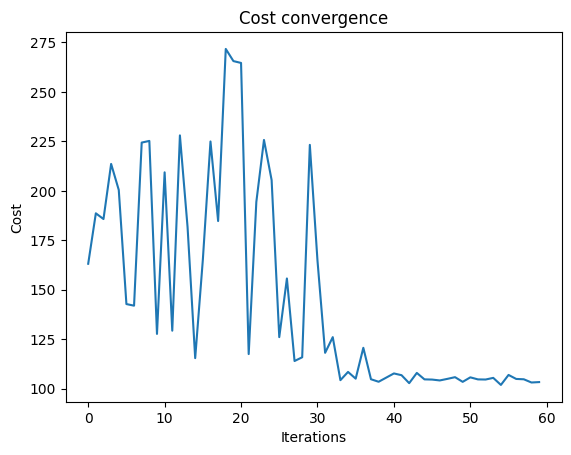

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=1)
axes.plot(combi.cost_trace)
axes.set_xlabel("Iterations")
axes.set_ylabel("Cost")
axes.set_title("Cost convergence")

## Optimization Results

We can also examine the statistics of the algorithm. In order to get samples with the optimized parameters, we call the `sample` method:

In [10]:
optimization_result = combi.sample(optimized_params)
optimization_result.sort_values(by="cost").head(5)

,solution,probability,cost
1881,"{'x': [1, 0, 1, 1, 0, 0, 0, 1], 'independent_r...",0.000488,4.0
121,"{'x': [0, 1, 1, 1, 0, 1, 0, 0], 'independent_r...",0.000488,24.0
942,"{'x': [0, 1, 0, 1, 1, 1, 0, 0], 'independent_r...",0.000488,24.0
1920,"{'x': [0, 0, 0, 0, 1, 1, 1, 1], 'independent_r...",0.000488,24.0
1338,"{'x': [0, 1, 0, 1, 1, 1, 0, 0], 'independent_r...",0.000488,24.0


We also want to compare the optimized results to uniformly sampled results:

In [11]:
uniform_result = combi.sample_uniform()

And compare the histograms:

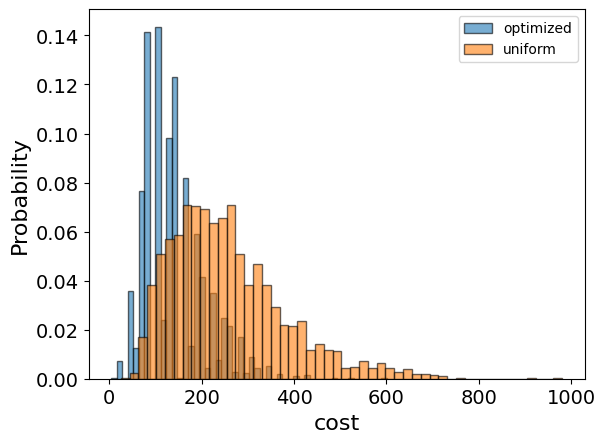

In [12]:
optimization_result["cost"].plot(
    kind="hist",
    bins=50,
    edgecolor="black",
    weights=optimization_result["probability"],
    alpha=0.6,
    label="optimized",
)
uniform_result["cost"].plot(
    kind="hist",
    bins=50,
    edgecolor="black",
    weights=uniform_result["probability"],
    alpha=0.6,
    label="uniform",
)
plt.legend()
plt.ylabel("Probability", fontsize=16)
plt.xlabel("cost", fontsize=16)
plt.tick_params(axis="both", labelsize=14)

Let us plot the solution:

In [13]:
best_solution = optimization_result.solution[optimization_result.cost.idxmin()]
best_solution = [best_solution["x"][i] for i in range(len(best_solution["x"]))]
best_solution

[1, 0, 1, 1, 0, 0, 0, 1]

In [14]:
print(
    f"Quantum Solution: num_sets={int(sum(best_solution))}, sets={[sub_sets[i] for i in range(len(best_solution)) if best_solution[i]]}"
)

Quantum Solution: num_sets=4, sets=[[1, 2, 3, 4], [6, 7], [8, 9, 10], [2, 5, 8]]


## Comparison to a classical solver

Lastly, we can compare to the classical solution of the problem:

In [15]:
from pyomo.opt import SolverFactory

solver = SolverFactory("couenne")
solver.solve(set_cover_model)
classical_solution = [
    int(pyo.value(set_cover_model.x[i])) for i in range(len(set_cover_model.x))
]
print("Classical solution:", classical_solution)

Classical solution: [1, 1, 1, 1, 0, 0, 0, 0]


In [16]:
print(
    f"Classical Solution: num_sets={int(sum(classical_solution))}, sets={[sub_sets[i] for i in range(len(classical_solution)) if classical_solution[i]]}"
)

Classical Solution: num_sets=4, sets=[[1, 2, 3, 4], [2, 3, 4, 5], [6, 7], [8, 9, 10]]



## References

<a id='MVC'>[1]</a>: [Integer Programming (Wikipedia).](https://en.wikipedia.org/wiki/Integer_programming)

<a id='QAOA'>[2]</a>: [Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint arXiv:1411.4028 (2014).](https://arxiv.org/abs/1411.4028)

<a id='cvar'>[3]</a>: [Barkoutsos, Panagiotis Kl, et al. "Improving variational quantum optimization using CVaR." Quantum 4 (2020): 256.](https://arxiv.org/abs/1907.04769)
